## Problem set 9

**Problem 0** (-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)

Make sure you are in the DATA1030 environment.

In [1]:
from __future__ import print_function
from distutils.version import LooseVersion as Version
import sys

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == min_ver:
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(sys.version)
if pyversion >= "3.7":
    print(OK, "Python version is %s" % sys.version)
elif pyversion < "3.7":
    print(FAIL, "Python version 3.7 is required,"
                " but %s is installed." % sys.version)
else:
    print(FAIL, "Unknown Python version: %s" % sys.version)

    
print()
requirements = {'numpy': "1.18.5", 'matplotlib': "3.2.2",'sklearn': "0.23.1", 
                'pandas': "1.0.5",'xgboost': "1.1.1", 'shap': "0.35.0"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]

[ OK ] numpy version 1.18.5 is installed.
[ OK ] matplotlib version 3.2.2 is installed.
[ OK ] sklearn version 0.23.1 is installed.
[ OK ] pandas version 1.0.5 is installed.
[ OK ] xgboost version 1.1.1 is installed.
[ OK ] shap version 0.35.0 is installed.


You will work with the [hand postures dataset](https://archive.ics.uci.edu/ml/datasets/Motion+Capture+Hand+Postures) in this problem set. We already split and preprocessed the dataset in PS4 problem 2 and we will build on the solution. We provide our solution for PS4 problem 2a as a starting point. Keep the missing values in the dataset, do not drop points or columns, or impute values.

**Problem 1a** (10 points)

We will predict the hand postures of a previously unseen user and we will use XGBoost in Problem 1.

Study the target variable and choose an evaluation metric. Please explain why you chose the metric (1-2 paragraphs). (3 points)

Train an XGBoost model on the splitted and preprocessed data. Use early stopping and tune the max_depth parameter. (5 points)

Accumulate the training, validation, and test scores. (2 points)

NOTE: I recommend you print out partial results to see how the training progresses. If it takes a long time to train the models, change `n_splits` in `GroupShuffleSplit` to 1 instead of 3.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('data/Postures.csv', skiprows=[1])
df.replace("?", np.nan, inplace=True)    # replace ? as nan
df.head()

## delete these lines
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
max_depth = [1,3,10,30,100]
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}
train_scores = []
val_scores = []
test_scores = []
max_depths = []
##


# extract X, y and User
y = df['Class']
User = df['User']
X = df.iloc[:, 2:]
# init GroupShuffleSplit as follows
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
for nth_split, (other_idx, test_idx) in enumerate(gss.split(X, y, User)):    # group by User
    # extract X_other, X_test, y_other, y_test, User_other, User_test
    X_other, y_other = X.iloc[other_idx], y.iloc[other_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    User_other = User.iloc[other_idx]
    User_test = User.iloc[test_idx]
    # init GroupKFold, 3 folds
    gkf = GroupKFold(n_splits=3)
    # create a temporary dictionary for kfold and test data
    random_split_tmp = {'kfold_train':[], 'kfold_cv':[], 'test': []}
    for train_idx, cv_idx in gkf.split(X_other, y_other, User_other):    # group by User_other
        # extract X_train, X_train, y_cv, y_cv, User_train, User_cv
        X_train, X_cv = X_other.iloc[train_idx], X_other.iloc[cv_idx]
        y_train, y_cv = y_other.iloc[train_idx], y_other.iloc[cv_idx]
        User_train = User_other.iloc[train_idx]
        User_cv = User_other.iloc[cv_idx]
        # check if ant user exist in any of the two splits
        if set(User_train.unique()) == set(User_cv.unique()) or\
           set(User_train.unique()) == set(User_test.unique()) or\
           set(User_cv.unique()) == set(User_test.unique()):
            raise ValueError('User exists in two or more of the splits')
        # init StandardScaler
        ss = StandardScaler()
        # fit_transform on train
        X_train = ss.fit_transform(X_train)
        # transform cv and test
        X_cv = ss.transform(X_cv)
        X_test = ss.transform(X_test)

        print('users in train:',User_train.unique())
        print('users in CV:',User_cv.unique())
        print('users in test:',User_test.unique())
        
        for d in max_depth:
            param_grid['max_depth'] = [d]
            XGB = xgboost.XGBClassifier()
            XGB.set_params(**ParameterGrid(param_grid)[0])

            XGB.fit(X_train,y_train,early_stopping_rounds=50,eval_set=[(X_cv, y_cv)], verbose=False)
            y_train_pred = XGB.predict(X_train)
            y_cv_pred = XGB.predict(X_cv)
            y_test_pred = XGB.predict(X_test)
            
            train_scores.append(accuracy_score(y_train,y_train_pred))
            val_scores.append(accuracy_score(y_cv,y_cv_pred))
            test_scores.append(accuracy_score(y_test,y_test_pred))
            max_depths.append(d)


users in train: [ 2  5  7  8  9 11 14]
users in CV: [ 1  4  6 13]
users in test: [ 0 10 12]
users in train: [ 1  4  6  8  9 13 14]
users in CV: [ 2  5  7 11]
users in test: [ 0 10 12]
users in train: [ 1  2  4  5  6  7 11 13]
users in CV: [ 8  9 14]
users in test: [ 0 10 12]


**Problem 1b** (10 points)

Create a figure which shows the mean and stdev of the train and validation scores as a function of the max_depth parameter. (5 points)

Determine which max_depth parameter gives the best validation score. (2 points)

Write a paragraph about the train and validation scores and any peculiarity that you see on the plot with respect to high bias and high variance. (2 points)

Finally, calculate the mean and stdev of the test score based on the best max_depth value. (1 point)

[0.82177438 0.86395777 0.99307044 0.99833414 0.99821525]
[0.61847343 0.64093185 0.68797338 0.69550197 0.69520936]
[0.50163218 0.43953845 0.50789123 0.48135059 0.49850975]


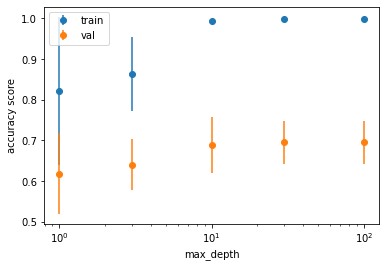

30
0.48135059184194845
0.19182525229230873


In [3]:
import matplotlib.pyplot as plt



mean_train = np.zeros(len(max_depth))
std_train = np.zeros(len(max_depth))
mean_val = np.zeros(len(max_depth))
std_val = np.zeros(len(max_depth))
mean_test = np.zeros(len(max_depth))
std_test = np.zeros(len(max_depth))

train_scores = np.array(train_scores)
val_scores = np.array(val_scores)
test_scores = np.array(test_scores)
max_depths = np.array(max_depths)

for d in range(len(max_depth)):
    mean_train[d] = np.mean(train_scores[max_depths == max_depth[d]])
    std_train[d] = np.std(train_scores[max_depths == max_depth[d]])
    mean_val[d] = np.mean(val_scores[max_depths == max_depth[d]])
    std_val[d] = np.std(val_scores[max_depths == max_depth[d]])
    mean_test[d] = np.mean(test_scores[max_depths == max_depth[d]])
    std_test[d] = np.std(test_scores[max_depths == max_depth[d]])

print(mean_train)
print(mean_val)
print(mean_test)


plt.errorbar(max_depth,mean_train,yerr=std_train,fmt='o',label='train')
plt.errorbar(max_depth,mean_val,yerr=std_val,fmt='o',label='val')
plt.semilogx()
plt.ylabel('accuracy score')
plt.xlabel('max_depth')
plt.legend()
plt.show()

print(max_depth[np.argmax(mean_val)])
print(mean_test[np.argmax(mean_val)])
print(std_test[np.argmax(mean_val)])

# in my case, max_depth = 30 gives the best validation score and the corresponding mean test score is 0.48.
# the plot shows high bias for low max_depth values, but we don't see overfitting. 
# There is no scenario where the trainins score is high but the validation score starts to decrease.


**Problem 2a** (10 points)

You will start to implement the reduced features model. First, calculate what patterns exist in the test set and how many points belong to each pattern. (4 points)

Then for each pattern, collect the corresponding subgroup from the training set. This subgroup would be used to train a classification model. (3 points)

For each subgroup, check the target variable and print out the unique class labels and how many points belong to each class. (3 points)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler

df = pd.read_csv('data/Postures.csv', skiprows=[1])
df.replace("?", np.nan, inplace=True)    # replace ? as nan
df.head()

# extract X, y and User
y = df['Class']
User = df['User']
X = df.iloc[:, 2:]
# init GroupShuffleSplit as follows
gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
for nth_split, (other_idx, test_idx) in enumerate(gss.split(X, y, User)):    # group by User
    # extract X_other, X_test, y_other, y_test, User_other, User_test
    X_other, y_other = X.iloc[other_idx], y.iloc[other_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    User_other = User.iloc[other_idx]
    User_test = User.iloc[test_idx]
    # init GroupKFold, 3 folds
    gkf = GroupKFold(n_splits=3)
    # create a temporary dictionary for kfold and test data
    random_split_tmp = {'kfold_train':[], 'kfold_cv':[], 'test': []}
    for train_idx, cv_idx in gkf.split(X_other, y_other, User_other):    # group by User_other
        # extract X_train, X_train, y_cv, y_cv, User_train, User_cv
        X_train, X_cv = X_other.iloc[train_idx], X_other.iloc[cv_idx]
        y_train, y_cv = y_other.iloc[train_idx], y_other.iloc[cv_idx]
        User_train = User_other.iloc[train_idx]
        User_cv = User_other.iloc[cv_idx]
        # check if ant user exist in any of the two splits
        if set(User_train.unique()) == set(User_cv.unique()) or\
           set(User_train.unique()) == set(User_test.unique()) or\
           set(User_cv.unique()) == set(User_test.unique()):
            raise ValueError('User exists in two or more of the splits')
        # init StandardScaler
        ss = StandardScaler()
        # fit_transform on train
        X_train = ss.fit_transform(X_train)
        # transform cv and test
        X_cv = ss.transform(X_cv)
        X_test = ss.transform(X_test)

        print('users in train:',User_train.unique())
        print('users in CV:',User_cv.unique())
        print('users in test:',User_test.unique())
        
        # DELETE CODE UNDER THIS LINE
        
        df_test = pd.DataFrame(data=X_test,columns=X.columns)
        df_train = pd.DataFrame(data=X_train,columns=X.columns)
        y_train = y_train.reset_index(drop=True)
        
        mask = df_test.isnull()
        unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
        for i in range(len(counts)):
            print(unique_rows[i],counts[i])
        
            sub_X_train = pd.DataFrame()
            sub_Y_train = pd.DataFrame()
            # 1.cut the feature columns that have nans in the according sub_X_test
            sub_X_train = df_train[df_train.columns[~unique_rows[i]]]
            # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
            sub_X_train = sub_X_train.dropna()
            # 3.cut the sub_Y_train and sub_y_CV accordingly
            sub_Y_train = y_train.iloc[sub_X_train.index]
            
            # unique classes and their counts in train
            print(np.unique(sub_Y_train,return_counts=True))


users in train: [ 2  5  7  8  9 11 14]
users in CV: [ 1  4  6 13]
users in test: [ 0 10 12]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False] 25
(array([2]), array([6]))
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True] 5201
(array([1, 2, 5]), array([  48, 4824, 1471]))
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True] 1006
(array([1, 2, 4, 5]), array([  48, 6740,   12, 5171]))
[False False False False False False False False False False False False
 False False False False False False

**Problem 2b** (5 points)

The reduced feature model might not always be a good approach especially in classification. As you saw in 2a, some subgroups have only a small number of data points or contain less than 5 of the original classification labels. Answer the two questions below. There is no need to code.

Q1: What can you do if all points in a training set subgroup belong to one class? (2 points)

Q2: What issues will you encounter if one training set subgroup contains less than 5 but more than 1 of the original classification labels? If you want, implement the reduced features model to answer this question. You can also figure it out without coding though. (3 points)

Hint 1: you cannot collect more data. That's often not possible or too expensive so you need to work with the data you are given.

Hint 2: read through the LabelEncoder manual.

Q1: if a pattern is so specific that all points in a training set subgroup belong to one class, you can just predict that class for the corresponding points in the test set.

Q2: You'll need to use the LabelEncoder to because some class labels will be missing. When you accumulate the predictions, you'll need to use the inverse_transform of the encoder to get back the original 5 labels.